# Proyecto 03 - Sistemas de Recomendación

## Dataset: STEAM

### Presentación de los Datos a utilizar.

* *Trabajaremos con los datos de la plataforma de videojuegos de STEAM.* Que incluyen reseñas e información de juegos de la plataforma de juegos online. El conjunto de datos contiene 7,793,069 reseñas, 2,567,538 usuarios y 32,135 juegos. Además del texto de revisión, los datos también incluyen las horas de juego de los usuarios en cada revisión.

---
Antes de empezar a trabajar comparto la ubicación del repositorio completo de GitHub:

https://github.com/datosalaobra/ACAMICA_PROJECT_3.git

---

## Importación de librerías

In [1]:
# Librería para medir tiempos
from datetime import datetime

# Librerías para la importación de archivos
import gzip
import pandas as pd
import numpy as np

# Liberías para el tratamiento de los datos
import re
import string
from string import digits
from itertools import count
from scipy.stats.mstats import winsorize
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer


# Librerías para gráficos
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors

# Librerías para modelado
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import SVD, SVDpp, SlopeOne, BaselineOnly
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import RandomizedSearchCV


In [2]:
# Tomamos el tiempo de inicio de ejecución
start_time = datetime.now()

In [3]:
WORK_WITH_SAMPLE = False # Línea que nos permite trabajar con una muestra de nuestros datos.

**¡Atención estimado evaluador!** Esta línea le permite optimizar su tiempo. A considerar, este es un cuaderno que tiene un tiempo estimado de duración 4 horas 34 minutos. Para poder verificar que ninguna línea arroja error sin tener que ocupar ese tiempo le recomiendo que simplemente reemplace el `False` de la celda anterior por un `True`. De esta manera podrá trabajar con una muestra parcial de los datos, ayudando a que el código “corra” mucho más rápido y termine antes su evaluación. ¡Ah! una sola cosa más, antes de hacerlo le pido por favor vea los resultados que trae el cuaderno con mi entrega simplemente para que coincidan con mi análisis. 

Muchas gracias

---

## **Load Datos Reviews**

In [4]:
# Función para descargar los datos comprimidos de las reviews,
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

In [5]:
# Importo los datos de las reviews.
contador = 0
data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.
n = 10
for l in parse('steam_reviews.json.gz'):
    if contador%n == 0:
        data_reviews.append(l)
    else:
        pass
    contador += 1

In [6]:
# Transformo los datos en un dataframe.
data_reviews = pd.DataFrame(data_reviews)

In [7]:
# Imprimo las primeras 5 instancias.
data_reviews.head()

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,Ariman1,13.2,1386.0,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN,NaN,NaN
2,freakfantom,0.1,1706.0,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,NaN,NaN,NaN
3,The_Cpt_FROGGY,7.8,2217.0,631920,0,2017-12-11,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,False,1,76561198003030375,Product received for free,NaN
4,the_maker988,8.2,18.0,35140,7,2018-01-02,"This game was way to linear for me, and compar...",False,1,76561198353396844,NaN,NaN


In [8]:
# Imprimo las últimas 5 instancias.
data_reviews.tail()

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
779302,Vidaar,783.5,353.0,252490,1,2013-12-11,Summary: Rust is a survival game created by Fa...,True,10217,NaN,NaN,NaN
779303,Nikolai Belinski,55.1,204.0,252490,1,2013-12-11,Coolest Game Eva,True,10218,NaN,NaN,NaN
779304,RancorZealot,203.5,173.0,252490,1,2013-12-11,Should you buy RUST? Uh... YES. The BEST Survi...,True,10219,76561197963920623,NaN,NaN
779305,Jerry,139.8,79.0,252490,1,2013-12-11,Great game!,True,10220,76561198042664856,NaN,NaN
779306,Helk,15375.0,98.0,252490,1,2013-12-11,I love this game!,True,10221,NaN,NaN,36.0


In [9]:
# Elimino las columnas que no voy a utilizar (por no ser relevantes para nuestro sr.)
data_reviews = data_reviews.drop (['products','page_order','date', 'early_access',
               'page','compensation'], axis =1)
data_reviews.head()

,username,hours,product_id,text,user_id,found_funny
0,Chaos Syren,0.1,725280,This would not be acceptable as an entertainme...,NaN,NaN
1,Ariman1,13.2,328100,Addictive RPG ! Works fine on linux though it ...,NaN,NaN
2,freakfantom,0.1,725280,Прикольная стрелялка. Взял дешево на распродаже.,NaN,NaN
3,The_Cpt_FROGGY,7.8,631920,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,76561198003030375,NaN
4,the_maker988,8.2,35140,"This game was way to linear for me, and compar...",76561198353396844,NaN


In [10]:
# Verifico cuales son las columnas a las que le faltan datos.
data_reviews.isnull().sum()

username            0
hours            2637
product_id          0
text                0
user_id        461967
found_funny    659143
dtype: int64

* ¡Alerta! La columna con el ID del usuario tiene muchos NaNs.
* Es una columna  **MUY IMPORTANTE**. Es un dato clave que necesitamos para luego poder construir nuestra matriz de utilidad. Vamos a mejorarla creando una columna con un nuevo identificador por cada usuario. 


In [11]:
# Instanciamos el encoder y transformamos los datos.
encoder= LabelEncoder()
data_reviews['User_cleanID']=encoder.fit_transform(data_reviews.username.values)

In [12]:
# Eliminamos la columna con el ID del usuario original.
# aprovechamos y también eliminamos 'found_funny' que como vimos también tiene muchos NaNs también.
data_reviews = data_reviews.drop (['user_id', 'found_funny'], axis =1) 
# Renombro la columna con el ID sintético
data_reviews.rename (columns = {'User_cleanID':'user_id'}, inplace = True)                                  
data_reviews.head()

,username,hours,product_id,text,user_id
0,Chaos Syren,0.1,725280,This would not be acceptable as an entertainme...,62543
1,Ariman1,13.2,328100,Addictive RPG ! Works fine on linux though it ...,26902
2,freakfantom,0.1,725280,Прикольная стрелялка. Взял дешево на распродаже.,434604
3,The_Cpt_FROGGY,7.8,631920,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,347904
4,the_maker988,8.2,35140,"This game was way to linear for me, and compar...",503851


In [13]:
# Calculo los principales estadísticos.
data_reviews.describe()

,hours,user_id
count,776670.000000,779307.000000
mean,111.843832,263409.694223
std,390.145376,154076.021074
min,0.000000,0.000000
25%,4.000000,130630.500000
50%,15.300000,260873.000000
75%,59.600000,391980.000000
max,28164.000000,540340.000000


In [14]:
# Removemos outliers en los percentiles 5 y 95 para las horas.
data_reviews['hours'] = winsorize(data_reviews['hours'], limits=(0, 0.05))

In [15]:
# Revisamos que el máximo de horas sea razonable.
data_reviews.hours.max()

547.0

In [16]:
# Veo los tipos datos para asegurarme que no haya valores númericos que esten cargados como cadena u objeto.
data_reviews.dtypes

username       object
hours         float64
product_id     object
text           object
user_id         int32
dtype: object

In [17]:
# Imprimo cuántas filas y columnas tiene nuestro dataset.
print('Cantidad de filas y columnas:',data_reviews.shape)

Cantidad de filas y columnas: (779307, 5)


## **Load Datos Games**

In [18]:
# Importo los datos de los juegos.
data_games = []
for l in parse('steam_games.json.gz'):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

In [19]:
# Imprimo las primeras 5 instancias. 
data_games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


In [20]:
# Imprimo las últimas 5 instancias. 
data_games.tail()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
32130,Ghost_RUS Games,"[Casual, Indie, Simulation, Strategy]",Colony On Mars,Colony On Mars,http://store.steampowered.com/app/773640/Colon...,2018-01-04,"[Strategy, Indie, Casual, Simulation]",1.49,http://steamcommunity.com/app/773640/reviews/?...,"[Single-player, Steam Achievements]",1.99,False,773640,"Nikita ""Ghost_RUS""",NaN,NaN
32131,Sacada,"[Casual, Indie, Strategy]",LOGistICAL: South Africa,LOGistICAL: South Africa,http://store.steampowered.com/app/733530/LOGis...,2018-01-04,"[Strategy, Indie, Casual]",4.24,http://steamcommunity.com/app/733530/reviews/?...,"[Single-player, Steam Achievements, Steam Clou...",4.99,False,733530,Sacada,NaN,NaN
32132,Laush Studio,"[Indie, Racing, Simulation]",Russian Roads,Russian Roads,http://store.steampowered.com/app/610660/Russi...,2018-01-04,"[Indie, Simulation, Racing]",1.39,http://steamcommunity.com/app/610660/reviews/?...,"[Single-player, Steam Achievements, Steam Trad...",1.99,False,610660,Laush Dmitriy Sergeevich,NaN,NaN
32133,SIXNAILS,"[Casual, Indie]",EXIT 2 - Directions,EXIT 2 - Directions,http://store.steampowered.com/app/658870/EXIT_...,2017-09-02,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...",NaN,http://steamcommunity.com/app/658870/reviews/?...,"[Single-player, Steam Achievements, Steam Cloud]",4.99,False,658870,"xropi,stev3ns",1 user reviews,NaN
32134,NaN,NaN,Maze Run VR,NaN,http://store.steampowered.com/app/681550/Maze_...,NaN,"[Early Access, Adventure, Indie, Action, Simul...",NaN,http://steamcommunity.com/app/681550/reviews/?...,"[Single-player, Stats, Steam Leaderboards, HTC...",4.99,True,681550,NaN,Positive,NaN


In [21]:
# Elimino las columnas que no voy a utilizar (por no ser relevantes para nuestro análisis.)
data_games = data_games.drop (['title','url','release_date', 
               'discount_price','reviews_url','metascore'], axis =1)
data_games.head()

,publisher,genres,app_name,tags,specs,price,early_access,id,developer,sentiment
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,"[Strategy, Action, Indie, Casual, Simulation]",[Single-player],4.99,False,761140,Kotoshiro,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,"[Free to Play, Strategy, Indie, RPG, Card Game...","[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,"[Free to Play, Simulation, Sports, Casual, Ind...","[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,"[Action, Adventure, Casual]",[Single-player],0.99,False,767400,彼岸领域,NaN
4,NaN,NaN,Log Challenge,"[Action, Indie, Casual, Sports]","[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN


In [22]:
# Verifico cuales son las columnas a las que le faltan datos.
data_games.isnull().sum()

publisher       8052
genres          3283
app_name           2
tags             163
specs            670
price           1377
early_access       0
id                 2
developer       3299
sentiment       7182
dtype: int64

In [23]:
# Calculo los principales estadísticos.
data_games.describe()

,publisher,genres,app_name,tags,specs,price,early_access,id,developer,sentiment
count,24083,28852,32133,31972,31465,30758.00,32135,32133,28836,24953
unique,8239,883,32094,15395,4649,162.00,2,32132,10992,18
top,Ubisoft,[Action],Soundtrack,"[Casual, Simulation]",[Single-player],4.99,False,612880,Ubisoft - San Francisco,Mixed
freq,385,1880,3,1292,2794,4278.00,30188,2,1259,4103


In [24]:
# Veo los tipos datos para asegurarme que no haya valores númericos que esten cargados como cadena u objeto.
data_games.dtypes

publisher       object
genres          object
app_name        object
tags            object
specs           object
price           object
early_access      bool
id              object
developer       object
sentiment       object
dtype: object

In [25]:
# Imprimo cuántas filas y columnas tiene nuestro dataset.
print('Cantidad de filas y columnas:',data_games.shape)

Cantidad de filas y columnas: (32135, 10)


## Preprocesamiento de Datos para el modelo.

In [26]:
# Antes, unifico ambos dataset para trabajar sobre una única entrada.
df= pd.merge(data_reviews, data_games, left_on='product_id', right_on='id')

In [27]:
# Definimos con cuantos datos hacemos nuestra muestra. 
if WORK_WITH_SAMPLE:
    df = df.sample(n=10000, random_state=42)

In [28]:
# Convertimos a numéricos todos aquellos atributos que debieran serlo.
df = df.apply(pd.to_numeric, errors='ignore')

# Quitamos las columnas que contengan únicamente NaNs.
df = df.dropna(how='all', axis= 1)

---
### Limpieza y clasificación de los principales atributos.

* Primero trabajaremos con la columna 'text' a la que transformaremos en nuestro TARGET para el modelo. Para eso vamos a normalizar su contenido y lo llevamos a la raíz a través del proceso LEMMATIZER.
* Elegimos trabajar con el Lemmatizer porque queremos realizar el proceso teniendo en cuenta cuál es el rol que la palabra cumple en el texto. Necesitamos que su accionar sea distinto si la palabra está actuando como verbo, sustantivo, etc.
* **Objetivo: Luego de preprocesamiento a través del análisis de sentimientos de los comentarios llegar a obtener un "Rating".**


In [29]:
# Creamos una función para darle el argumento extra de contexto a nuestro Lemmatizer.
# la necesitamos para definir los valores de POS (Part Of Speech) que entiende wordnet_lemmatizer.
def get_wordnet_pos(word):
    """Asignamos la etiqueta POS al primer carácter """
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [30]:
# Definimos el lemmatizer
lemmatizer = WordNetLemmatizer()
# Instanciamos las stopwords
stopwords = nltk.corpus.stopwords.words('english')
# Recorremos todos los comentarios y le vamos aplicando la Normalizacion y luego el lemmatizer a cada uno.
comentarios_list=[]
for comentarios in df.text:
    # Vamos a reemplzar los caracteres que no sean leras por espacios
    comentarios=re.sub("[^a-zA-Z]"," ",str(comentarios))
    # Pasamos todo a minúsculas
    comentarios=comentarios.lower()
    # Tokenizamos para separar las palabras de los comentarios
    comentarios=nltk.word_tokenize(comentarios)
    
    # Aplicamos la funcion para buscar la raiz de las palabras
    comentarios=[lemmatizer.lemmatize(palabra, get_wordnet_pos(palabra)) for palabra in comentarios]
    
    # Eliminamos las palabras de menos de 3 letras
    comentarios = [palabra for palabra in comentarios if len(palabra)>3]
    # Sacamos las Stopwords
    comentarios = [palabra for palabra in comentarios if not palabra in stopwords]
      
    # Por último volvemos a unir el texto
    comentarios=" ".join(comentarios)
    
    # Armamos una lista con todos los comentarios normalizados
    comentarios_list.append(comentarios)

In [31]:
# Agregamos al dataset una columna llamado lemma_comments que contenga el texto de los comentarios "lemmatizado".
df['lemma_comments'] = comentarios_list

In [32]:
# Creamos una función que nos permita extrapolar la polaridad de los textos.
sia = SentimentIntensityAnalyzer()
def polaridad(text):
    return sia.polarity_scores(text)['compound']

In [33]:
# Decodificamos la polaridad de los comentarios para nuestro modelo.
df['lemma_comments']=df['lemma_comments'].apply(polaridad)

In [34]:
# Reescalamos los datos decodificados de las reviews para obtener un "Rating de 5 estrellas".
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(1,5))
comentarios_lemma_scaled = min_max_scaler.fit_transform(df[['lemma_comments']])
df_comentarios_lemma_scaled = pd.DataFrame(comentarios_lemma_scaled)
# Agregamos la columna de rating de 5 estrellas.
df[['rating']]=df_comentarios_lemma_scaled
df.head()

,username,hours,product_id,text,user_id,publisher,genres,app_name,tags,specs,price,early_access,id,developer,sentiment,lemma_comments,rating
0,Chaos Syren,0.1,725280,This would not be acceptable as an entertainme...,62543,Vyacheslav Shilikhin,"[Action, Adventure, Indie, Simulation]",Psi Project,"[Action, Adventure, Indie, Simulation]","[Single-player, Steam Trading Cards]",2.99,False,725280,Vyacheslav Shilikhin,Positive,0.7506,4.5012
1,freakfantom,0.1,725280,Прикольная стрелялка. Взял дешево на распродаже.,434604,Vyacheslav Shilikhin,"[Action, Adventure, Indie, Simulation]",Psi Project,"[Action, Adventure, Indie, Simulation]","[Single-player, Steam Trading Cards]",2.99,False,725280,Vyacheslav Shilikhin,Positive,0.0000,3.0000
2,Ariman1,13.2,328100,Addictive RPG ! Works fine on linux though it ...,26902,KISS ltd,"[Adventure, Indie, RPG]",Gunspell - Steam Edition,"[Adventure, RPG, Indie, Puzzle, Match 3]",[Single-player],14.99,False,328100,Ino-Co Plus,Mixed,0.2023,3.4046
3,dll3z,0.4,328100,do not buy this game,425514,KISS ltd,"[Adventure, Indie, RPG]",Gunspell - Steam Edition,"[Adventure, RPG, Indie, Puzzle, Match 3]",[Single-player],14.99,False,328100,Ino-Co Plus,Mixed,0.0000,3.0000
4,Nyazicat,2.2,328100,For some reason I entirely derped out and boug...,247075,KISS ltd,"[Adventure, Indie, RPG]",Gunspell - Steam Edition,"[Adventure, RPG, Indie, Puzzle, Match 3]",[Single-player],14.99,False,328100,Ino-Co Plus,Mixed,0.8074,4.6148


* Ahora nos quedamos con la columna 'sentiment' que corresponde a la calificación del juego en la plataforma. Agrupamos y observamos que trae.

In [35]:
df.groupby (['sentiment']).size()

sentiment
1 user reviews                187
2 user reviews                290
3 user reviews                284
4 user reviews                367
5 user reviews                345
6 user reviews                388
7 user reviews                317
8 user reviews                367
9 user reviews                318
Mixed                      120782
Mostly Negative              8352
Mostly Positive            108490
Negative                      317
Overwhelmingly Negative       675
Overwhelmingly Positive    148206
Positive                     4512
Very Negative                 347
Very Positive              385263
dtype: int64

In [36]:
# Creamos un diccionario para reemplazar los adjetivos calificativos con una puntuación estilo "Ranking".
df['sentiment']=df['sentiment'].map({'Mixed':5,'Overwhelmingly Negative':1,'Very Negative':2,
                                     'Negative':3,'Mostly Negative':4,'Mostly Positive':6,'Positive':7,
                                     'Very Positive':8,'Overwhelmingly Positive':9})

In [37]:
# Creo una función para limpiar caracteres de los string restantes.
def startedclean(text):
    text = re.sub("[^A-Za-z]"," ",str(text))
    return text

# Elimino caracteres de las columnas restantes de texto.
df['genres']= df['genres'].apply(startedclean)
df['tags']= df['tags'].apply(startedclean)
df['specs']= df['specs'].apply(startedclean)
df['developer']= df['developer'].apply(startedclean)

# Llevo todas las categóricas a minúsculas.
df= df.applymap(lambda s:s.lower() if type(s) == str else s)

# Ahora eliminaré todos los números y espacios adicionales de los datos de texto restantes.
remove_digits = str.maketrans('', '', digits)
df['genres']= df['genres'].apply(lambda x: x.translate(remove_digits))
df['tags']= df['tags'].apply(lambda x: x.translate(remove_digits))
df['specs']= df['specs'].apply(lambda x: x.translate(remove_digits))
df['developer']= df['developer'].apply(lambda x: x.translate(remove_digits))

# Imprimo cuántas filas y columnas tiene nuestro dataset.
print('Cantidad de filas y columnas:',df.shape)

Cantidad de filas y columnas: (779951, 17)


---
## Exploración del Dataset.
* Luego de nuestro EDA vamos a explorar el dataset respondiendo las principales preguntas que definirán que estrategia utilizaremos en nuestro sistema de recomendación. Manos a la obra.
* ¿Cuantos juegos hay en total?, ¿Y usuarios?, ¿Cuantos usuarios únicos tenemos?, ¿Cuantas calificaciones totales tenemos?


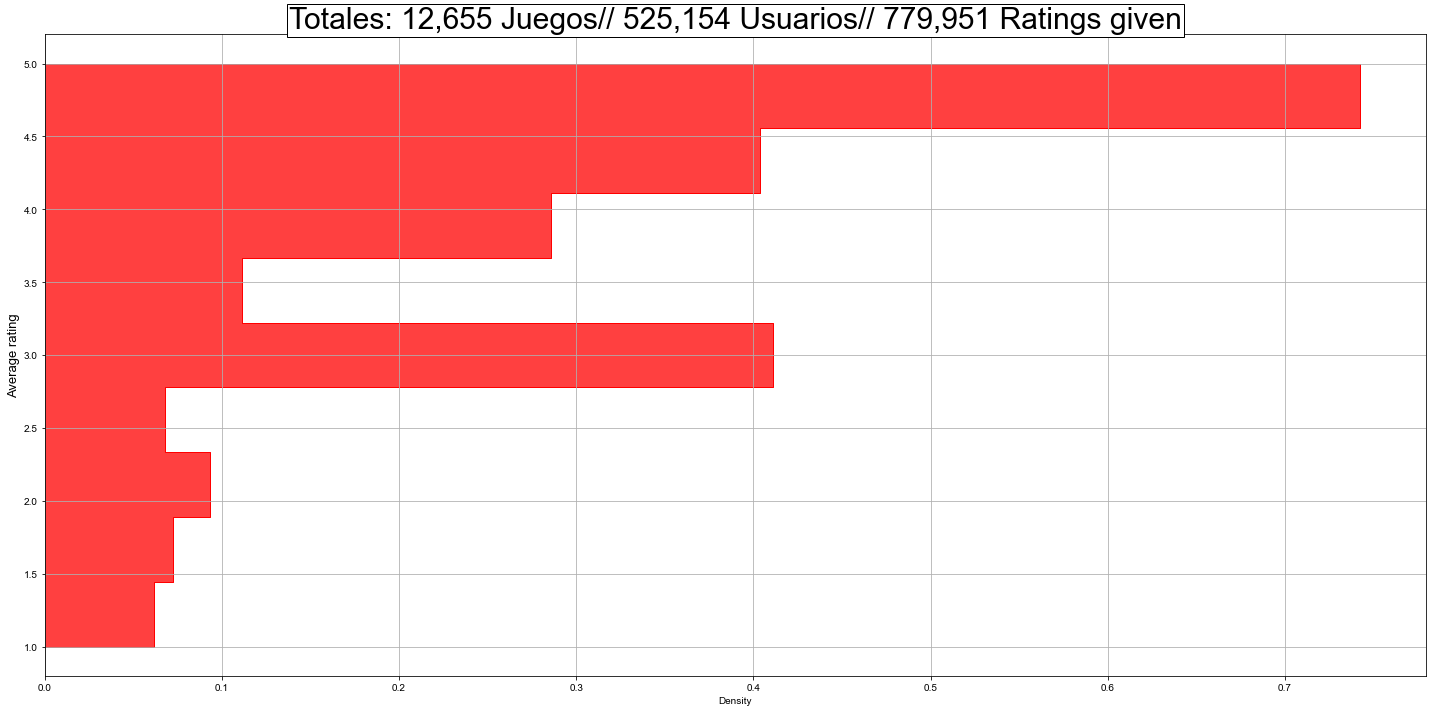

In [38]:
# Echemos un vistazo a la extensión del conjunto de datos y las calificaciones de los usuarios para responder nuestras preguntas iniciales.
#df.rating = df.rating.astype(int)

fig, ax = plt.subplots(figsize=[20,10])
plt.style.use('seaborn-white')
sns.histplot(data=df,y=df['rating'],ax=ax,bins=9, color='red', label='rating',palette='Set2',multiple='dodge',
             element='step',stat='density', common_norm=False)

# get movie count
games_count = df['app_name'].nunique()

# get customer count
user_count = df['username'].nunique() 

# get rating count
rating_count = df['rating'].count() 

ax.set_title('Totales: {:,} Juegos// {:,} Usuarios// {:,} Ratings given'.format(games_count, user_count, rating_count), 
             fontsize=30,bbox={'facecolor':'1','pad':2})
ax.set_ylabel('Average rating',fontsize=13)
plt.tight_layout()
plt.grid()
plt.show ()


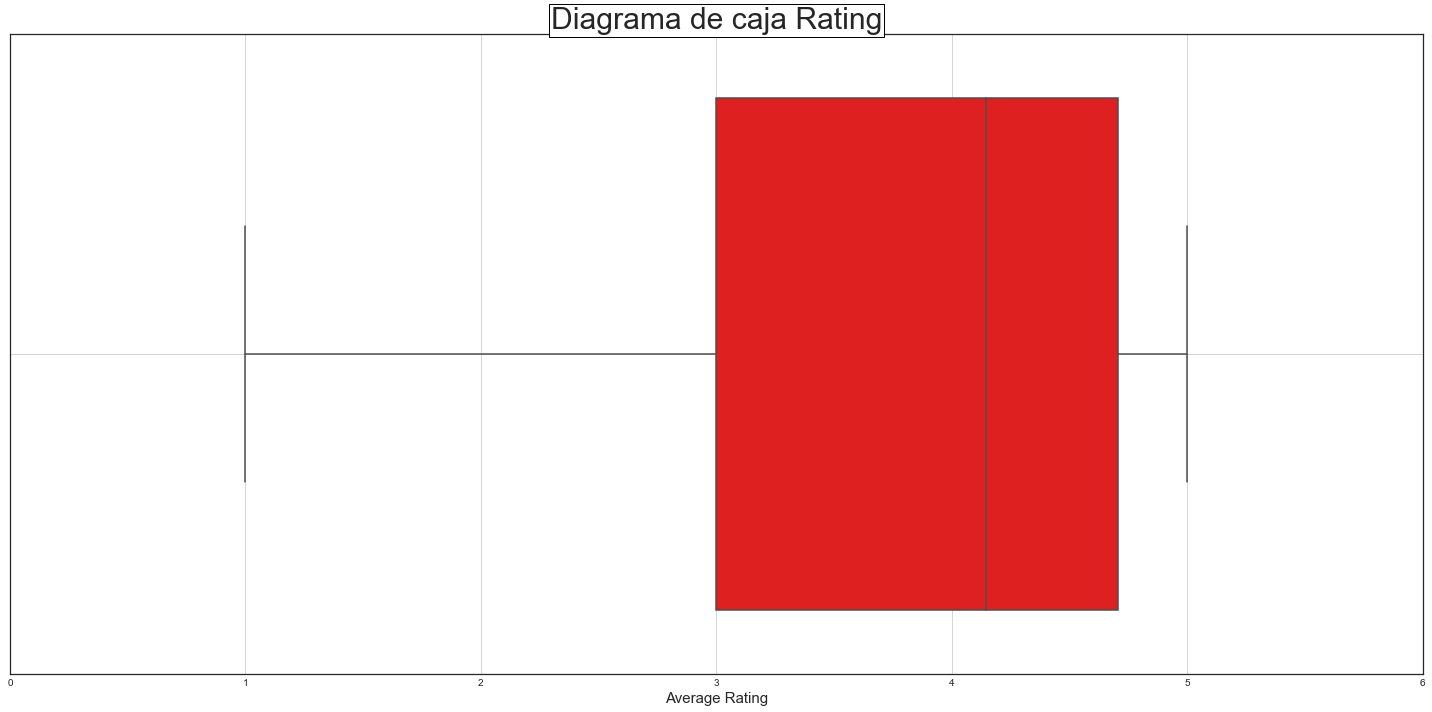

In [100]:
fig, ax = plt.subplots(figsize=[20,10])
ax= sns.boxplot (data =df, x ='rating',color='red')
ax.set_title ('Diagrama de caja Rating',
              fontsize=30,bbox={'facecolor':'1','pad':2})
ax.set_xlim(0,6)
plt.xlabel('Average Rating', fontsize=15)
plt.tight_layout()
plt.grid()
plt.show()

* Vemos claramente como en ambos gráficos la puntuación tiende a ser relativamente positiva (>= 3). Esto puede deberse a que los clientes insatisfechos tienden a irse en lugar de hacer un esfuerzo por calificar. Debemos tener esto en cuenta, los juegos de baja calificación significan que en general son realmente malos.
* Veamos como es la relación entre la Rating que le otorgan los usuarios y la calificación que le da la plataforma a sus juegos.

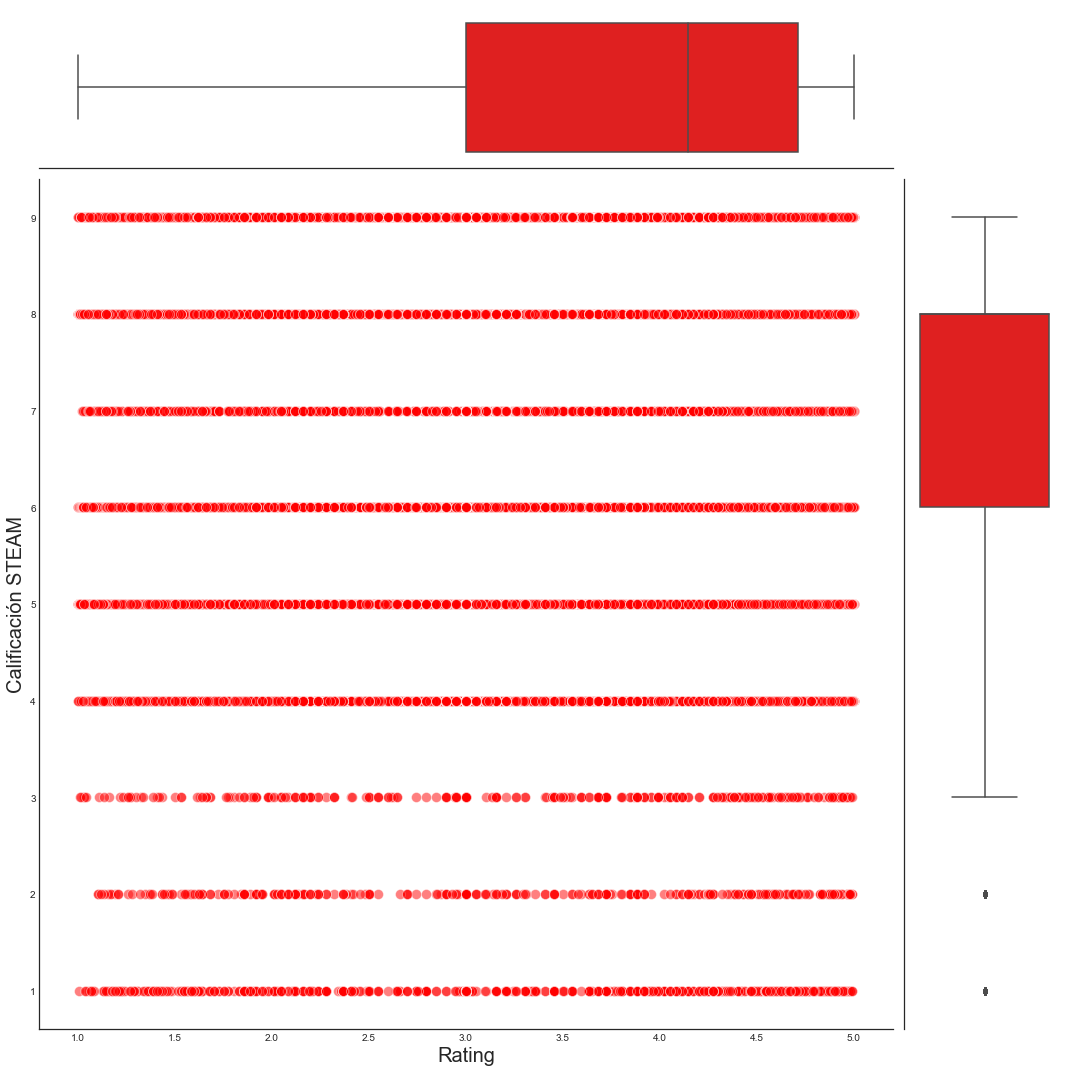

In [40]:
g = sns.JointGrid(data=df, x='rating', y='sentiment', height=15, palette='Set2')
g.plot_joint(sns.scatterplot, s=100, alpha=.5,color='red')
g.plot_marginals(sns.boxplot,color='red')
g.set_axis_labels(xlabel = 'Rating' , ylabel = 'Calificación STEAM' , fontsize=20 ) 
plt.tight_layout()
plt.show()

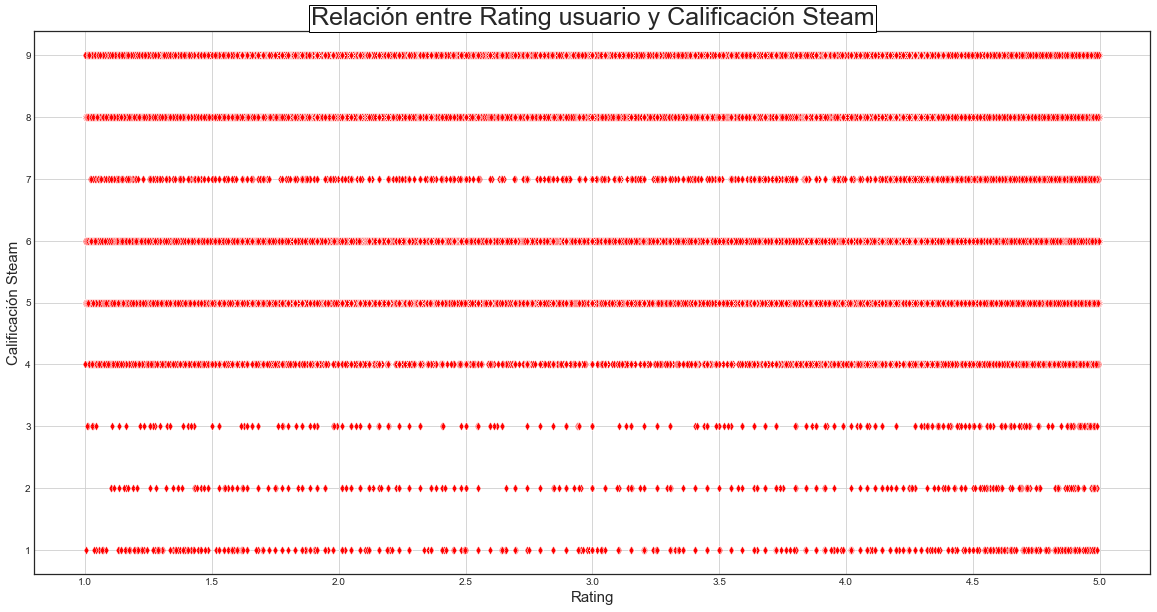

In [41]:
# Grafico para confirmar que después del recorte del dataset ya ninguna propiedad tiene una superficie cubierta mayor a la superficie total.
fig, ax = plt.subplots(figsize=[20,10])
ax=sns.scatterplot(data=df, x='rating', y='sentiment',color='red', marker= 'd',palette='Set2')
ax.set_title ('Relación entre Rating usuario y Calificación Steam',fontsize=25,bbox={'facecolor':'1','pad':2})
plt.xlabel('Rating', fontsize=15)
plt.ylabel('Calificación Steam', fontsize=15)
plt.grid()
plt.show()

* La plataforma califica de forma uniforme a sus juegos (si bien podemos observar que hay una pequeña concentración >= 4 es claro que no tiene relación con el rating).
* Queda en evidencia que no hay una relación entre la calificación del usuario y como categoriza Steam a sus juegos.
* Realizamos un Pairgrid como síntesis de lo trabajado hasta el momento.

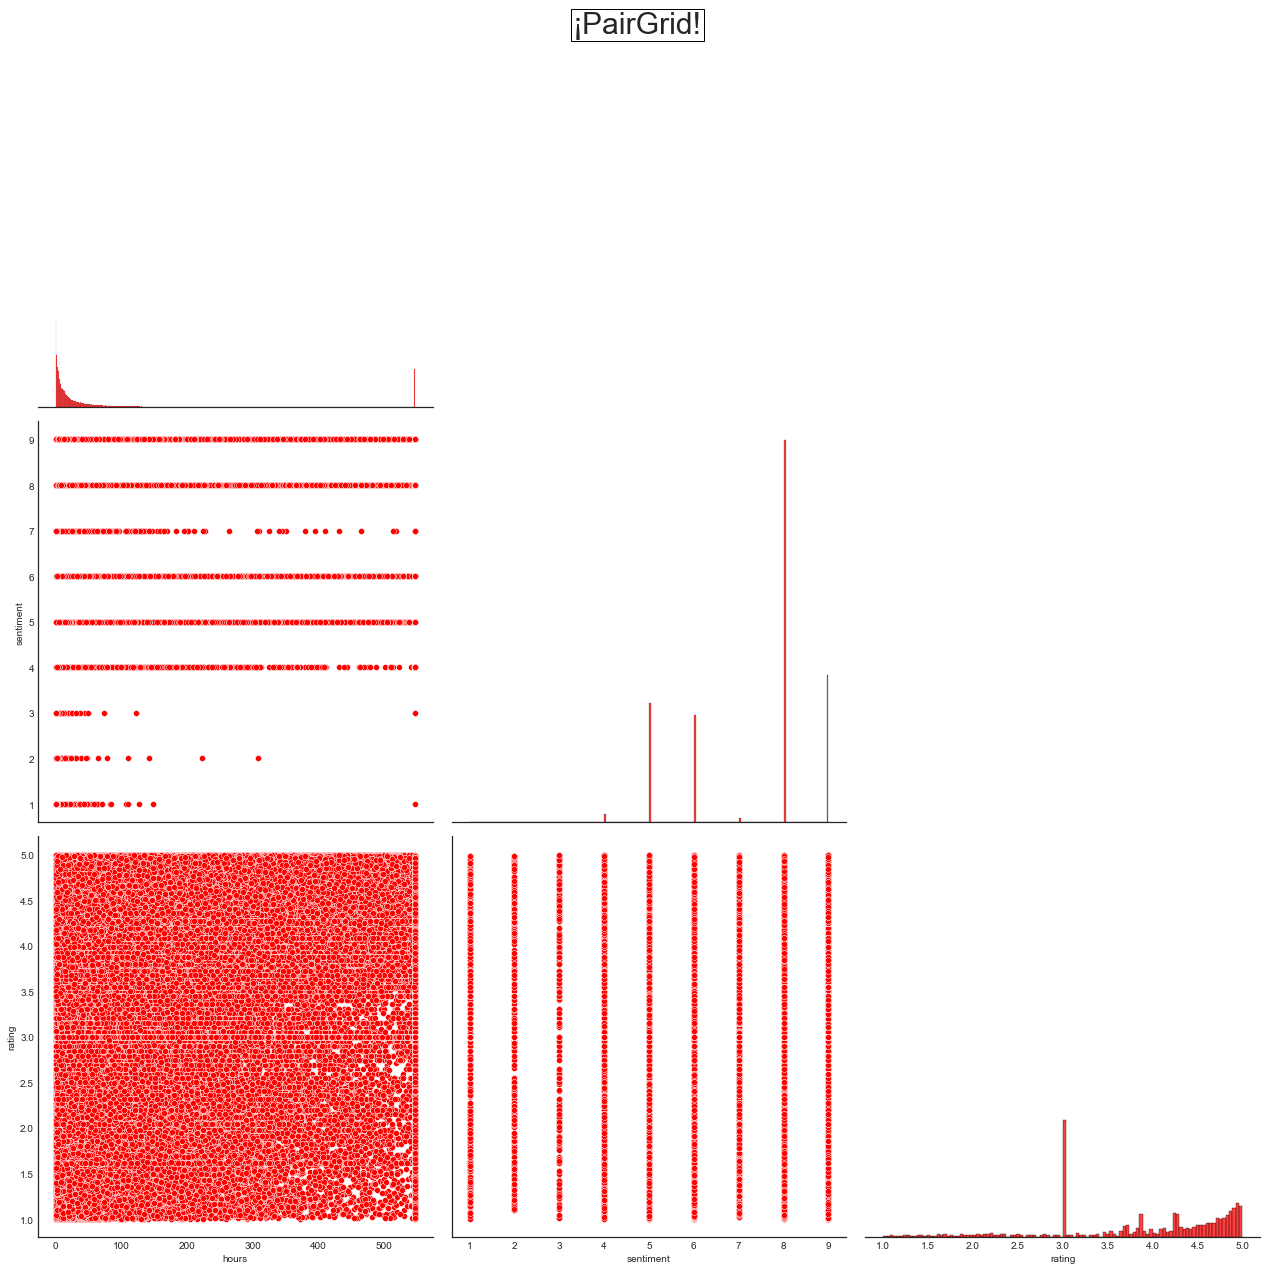

In [42]:
# Realizamos un PairGird que nos permita observar la relación entre horas, rating y calificación Steam.
g= sns.PairGrid(df,x_vars=['hours','sentiment','rating'],
                y_vars=['hours','sentiment','rating'],height=6,corner=True)
g.map_diag(sns.histplot,color='red')
g.map_offdiag(sns.scatterplot,color='red')
g.fig.suptitle ('¡PairGrid!',fontsize=30,bbox={'facecolor':'1','pad':2})
plt.show()

* A continuación vamos a rankear distintos atributos para enriquecer el análisis.
* **TOP 10 de usuarios que más actividad tienen. Por cantidad de comentarios:**

In [43]:
df_user = df.groupby(['username']).agg({'text' : 'count','rating':'median'})
df_user.sort_values('text',ascending=False).head(10)

,text,rating
username,,
alex,228,4.2498
123,213,3.8808
chris,191,4.1718
matt,175,4.0862
nick,158,4.2498
tom,153,3.8808
john,152,4.1293
dan,150,3.8992
jack,138,3.8808


* **TOP por cantidad de horas de juego:**

In [44]:
df_user = df.groupby(['username']).agg({'hours':'sum','rating': 'median' })
df_user.sort_values('hours',ascending=False).head(10)

,hours,rating
username,,
123,52583.3,3.8808
alex,18352.4,4.2498
chris,13128.6,4.1718
dan,13087.0,3.8992
matt,12951.7,4.0862
jack,12014.8,3.8808
zero,11733.1,4.2738
bob,11706.7,4.1978
tuong,10843.4,3.7636


* **TOP 10 de los juegos más populares (por cantidad de menciones):**

In [45]:
df_user = df.groupby(['app_name']).agg({'text' : 'count','rating':'median'})
df_user.sort_values('text',ascending=False).head(10)

,text,rating
app_name,,
team fortress 2,18373,3.8808
rust,10221,3.8430
borderlands 2,7321,4.1988
fallout 4,7113,3.9878
grand theft auto v,5976,3.0000
undertale,5710,4.2738
portal 2,5518,4.2738
warframe,5518,4.0846
dayz,5496,3.3062


* **TOP 10 de los juegos más populares (por cantidad de horas jugadas):**

In [46]:
df_user = df.groupby(['app_name']).agg({'hours':'sum','rating': 'median' })
df_user.sort_values('hours',ascending=False).head(10)

,hours,rating
app_name,,
team fortress 2,5844991.8,3.8808
rust,2475204.3,3.8430
warframe,1640168.4,4.0846
fallout 4,1332051.4,3.9878
garry's mod,1208473.6,3.8808
arma 3,1204103.6,4.0534
grand theft auto v,1090093.6,3.0000
ark: survival evolved,1084055.1,4.0212
borderlands 2,1051850.1,4.1988


* **TOP 10 de los juegos mejor rankeados por los usuarios:**

In [47]:
df_user = df.groupby(['app_name']).agg({'rating':'median','text' : 'count'})
df_user.sort_values('rating',ascending=False).head(10)

,rating,text
app_name,,
z. year one,4.9992,1
huenison,4.9982,1
geoid,4.9982,1
last days of spring 2,4.9980,1
house of snark 6-in-1 bundle,4.9978,1
sandra and woo in the cursed adventure,4.9974,1
galer: plague of heroes,4.9972,1
bai qu 百曲,4.9972,1
tatsu,4.9970,1


* Observamos que los juegos que tienen mejor calificación de rating no coinciden con los juegos más jugados.
* A considerar la "popularidad" del juego (mayor cantidad de horas) influye en el Rating. Cuantas más horas el promedio del rating tiende a bajar.
* Los juegos con mayor Rating tienen a tener escasas horas de juego.

**¡SPOILER ALERT!**
* No podemos ponderar igual el Rating de juegos que tienen muchas horas de juego vs juegos que están por debajo de las horas promedio de juego. 
* Esta información nos servirá más adelante.


* ¿Cuantos generos únicos tenemos?

In [48]:
print(len(df['genres'].unique()))

751


* **TOP 10 de los generos más populares:**

In [49]:
df_user = df.groupby(['genres']).agg({'text' : 'count','rating':'median'})
df_user.sort_values('text',ascending=False).head(10)

,text,rating
genres,,
action,86814,3.9176
action adventure,61439,4.1148
action free to play,36162,3.8808
action indie,33045,3.9534
strategy,29536,4.1891
action rpg,29298,4.1718
action adventure indie,25508,4.2738
adventure indie,23462,4.4860
rpg,22024,4.2498


* **TOP 10 de los generos mejor rankeados por los usuarios:**

In [50]:
df_user = df.groupby(['genres']).agg({'rating':'median','username' : pd.Series.nunique})
df_user.sort_values('rating',ascending=False).head(10)

,rating,username
genres,,
animation amp modeling design amp illustration photo editing video production,4.9934,1
casual indie massively multiplayer rpg early access,4.9866,1
casual rpg simulation early access,4.9657,2
massively multiplayer rpg strategy,4.9652,1
adventure indie racing strategy early access,4.9650,1
action massively multiplayer simulation early access,4.9550,1
animation amp modeling design amp illustration education photo editing software training utilities video production,4.9470,4
casual indie racing early access,4.9432,1
adventure casual indie massively multiplayer rpg strategy early access,4.9418,1


* ¿Cuantos desarrolladores de juegos únicos tenemos?

In [51]:
print(len(df['developer'].unique()))

8075


* **TOP 10 de los desarrolladores de juegos más populares:**

In [52]:
df_user = df.groupby(['developer']).agg({'text' : 'count','rating':'median'})
df_user.sort_values('text',ascending=False).head(10)

,text,rating
developer,,
valve,37372,3.8808
facepunch studios,14986,3.8430
bohemia interactive,11605,3.7224
bethesda game studios,10917,4.0534
gearbox software aspyr mac amp linux,7321,4.1988
ubisoft montreal,7087,4.0846
hi rez studios,6180,3.8808
daybreak game company,6165,3.5264
rockstar north,6050,3.0000


* **TOP 10 de los desarrolladores mejor rankeados por el usuario:**

In [53]:
df_user = df.groupby(['developer']).agg({'rating':'median','username' : pd.Series.nunique})
df_user.sort_values('rating',ascending=False).head(10)

,rating,username
developer,,
downward viral,4.9992,1
retream,4.9982,1
zen relay games,4.9982,1
feline fuelled games,4.9974,1
magenta factory zix solutions,4.9972,1
graham dodge,4.9972,1
sofuto geimu,4.9968,1
mightycodedragon,4.9958,1
factus games,4.9958,1


* **TOP 10 de juegos y desarrolladores por genero:**

In [54]:
df_user = df.groupby(['genres']).agg({'app_name':pd.Series.nunique,'developer' : pd.Series.nunique})
df_user.sort_values('app_name',ascending=False).head(10)

,app_name,developer
genres,,
action indie,954,843
action adventure indie,613,561
adventure indie,601,520
action,586,354
casual indie,498,407
action casual indie,378,333
strategy,355,217
adventure,343,197
adventure casual indie,338,290


* **TOP 10 de los juegos que más horas utilizaron los usuarios:**

In [55]:
df_user = df.groupby(['app_name']).agg({'hours':'sum','rating': 'median' })
df_user.sort_values('hours',ascending=False).head(10)

,hours,rating
app_name,,
team fortress 2,5844991.8,3.8808
rust,2475204.3,3.8430
warframe,1640168.4,4.0846
fallout 4,1332051.4,3.9878
garry's mod,1208473.6,3.8808
arma 3,1204103.6,4.0534
grand theft auto v,1090093.6,3.0000
ark: survival evolved,1084055.1,4.0212
borderlands 2,1051850.1,4.1988


## Machine Learning: Modelo benchmark
* Luego de nuestro EDA y el análisis exploratorio avanzaremos con los modelos.

## Sistema de recomendación: Filtro colaborativo.

In [56]:
# Guardamos una copia del dataset ya preprocesado.
df.to_csv('clean_data_sr.csv')

In [57]:
# Levantamos los datos del dataset depurado.
cleandata= pd.read_csv ('clean_data_sr.csv')# De esta manera optimizamos el tiempo.
cleandata.head()

,Unnamed: 0,username,hours,product_id,text,user_id,publisher,genres,app_name,tags,specs,price,early_access,id,developer,sentiment,lemma_comments,rating
0,0,chaos syren,0.1,725280,this would not be acceptable as an entertainme...,62543,vyacheslav shilikhin,action adventure indie simulation,psi project,action adventure indie simulation,single player steam trading cards,2.99,False,725280,vyacheslav shilikhin,7.0,0.7506,4.5012
1,1,freakfantom,0.1,725280,прикольная стрелялка. взял дешево на распродаже.,434604,vyacheslav shilikhin,action adventure indie simulation,psi project,action adventure indie simulation,single player steam trading cards,2.99,False,725280,vyacheslav shilikhin,7.0,0.0000,3.0000
2,2,ariman1,13.2,328100,addictive rpg ! works fine on linux though it ...,26902,kiss ltd,adventure indie rpg,gunspell - steam edition,adventure rpg indie puzzle match...,single player,14.99,False,328100,ino co plus,5.0,0.2023,3.4046
3,3,dll3z,0.4,328100,do not buy this game,425514,kiss ltd,adventure indie rpg,gunspell - steam edition,adventure rpg indie puzzle match...,single player,14.99,False,328100,ino co plus,5.0,0.0000,3.0000
4,4,nyazicat,2.2,328100,for some reason i entirely derped out and boug...,247075,kiss ltd,adventure indie rpg,gunspell - steam edition,adventure rpg indie puzzle match...,single player,14.99,False,328100,ino co plus,5.0,0.8074,4.6148


In [58]:
# Instanciamos la clase ‘Reader’ para analizar nuestros datos.
reader = Reader()

In [59]:
# Creamos el dataset en el formato que requiere la biblioteca.
data = Dataset.load_from_df(cleandata[['user_id', 'product_id', 'rating']], reader=reader)

In [60]:
# Dividimos nuestros datos en entrenamiento y testeo.
trainset, testset = train_test_split(data,random_state=42,test_size=.30)

### Modelo SVD: benchmarck.

In [61]:
# Creamos nuestro sistema de recomendación con hiperparámetros por defecto. ¿Por qué?
recommender = SVD() # Este será nuestro modelo benchmark.

In [62]:
# Lo entrenamos con nuestros datos de train.
recommender.fit(trainset)

In [63]:
# Realizamos predicciones con nuestros datos de test.
predictions = recommender.test(testset)

In [64]:
# Métricas de evaluación.
accuracy.mae(predictions)
accuracy.rmse(predictions)

MAE:  0.8093
RMSE: 0.9799


0.9798991082728535

### Optimización del modelo benchmark.

In [65]:
# Antes de avanzar con la optimización del modelo realizo un gráfico del desempeño del modelo.
rmse_test_means = []
factores = [1,2,4,8,16,32,64,128,256]
# Iteramos a través de un for el números de factores del SVD con validación cruzada.
for factor in factores:
    print(f'\nNúmero de Factores: {factor}')
    recommender = SVD(n_factors=factor)
    cv = cross_validate(recommender, data, measures=['RMSE'], cv = 3, verbose=True)
    rmse_test_means.append(np.mean(cv['test_rmse']))


Número de Factores: 1
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9764  0.9776  0.9779  0.9773  0.0006  
Fit time          7.69    7.91    7.88    7.83    0.10    
Test time         2.23    2.05    1.34    1.87    0.38    

Número de Factores: 2
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9754  0.9780  0.9781  0.9772  0.0013  
Fit time          7.83    7.81    7.91    7.85    0.04    
Test time         1.48    2.18    2.13    1.93    0.32    

Número de Factores: 4
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9761  0.9775  0.9785  0.9774  0.0010  
Fit time          8.76    8.45    8.46    8.56    0.14    
Test time         2.21    2.06    1.48    1.92    0.32    

Número de Factores: 8
Evaluating RMSE of algorithm SVD on 3 split(s).

    

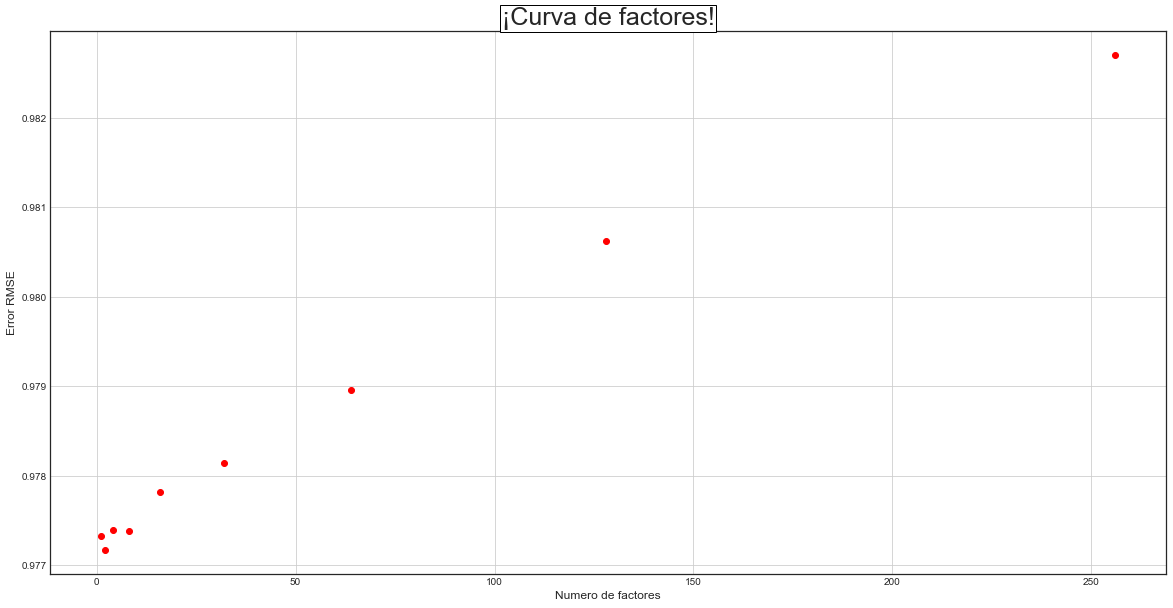

In [66]:
# Grafico los resultados de la iteración.
fig, ax = plt.subplots(figsize=[20,10])
plt.scatter(factores, rmse_test_means, color='red')
plt.xlabel('Numero de factores',fontsize=12)
plt.ylabel('Error RMSE',fontsize=12)
ax.set_title ('¡Curva de factores!',fontsize=25,bbox={'facecolor':'1','pad':2})
plt.grid()
plt.show()

In [67]:
# Utilizamos Randomized  en búsqueda de los mejores hiperparámetros y mejorar nuestro modelo.
random_grid = {'n_factors': [5,50,100],'n_epochs': [5, 10,20], 'lr_all': [0.001, 0.002, 0.005],
              'reg_all': [0.002, 0.02, 0.2]}
rs = RandomizedSearchCV(SVD, random_grid, measures=['rmse'], cv=3, n_jobs = -1)
# Lo entreno
rs.fit(data)

In [68]:
# Imprimo el mejor score obtenido y con que hiperparámetros lo conseguimos.

print(rs.best_score['rmse'])
print(rs.best_params['rmse'])

0.9784092239839081
{'n_factors': 5, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.002}


* La mejora con el método 'RandomSearch' no nos resulta satisfactorio. ¿Por qué sucede esto? Tenemos que seguir iterando comprenderlo y lograr resultados más óptimos.

### Interpretación y justificación en la elección del algoritmo SVD.

SVD nos permite aproximar la matriz de utilidad, que refleja la relación entre los juegos y los usuarios, los dos elementos clave de un sistema de recomendación. El objetivo es que cada par de ítem-usuario refleje la preferencia de ese usuario por ese juego.

El algoritmo nos facilita completar los espacios “en blanco” de la matriz de utilidad con la calificación que asignaría el usuario a ese juego y nos ayuda a detectar la similitud del comportamiento de los usuarios. 
Considerando esto podemos decir que cuanto más robusto sea nuestro Rating, resultados podemos esperar. Para robustecer el Rating tenemos que considerar la mayor cantidad de variables posible y construir un Rating por relevancia.

* Vamos a probar en la próxima sección construir un Rating por relevancia incluyendo los features más relevantes.
---
## Nuevo enfoque: proceso de mejora del input para nuestro modelo.
* Vamos a volver a explorar los datos. Queremos encontrar un camino alternativo que nos permita robustecer el Rating y mejorar nuestros resultados.
* Agrupamos los juegos por su popularidad (cantidad de menciones / comentarios), además le incorporamos la cantidad de horas de juego y el promedio de su rating.


In [69]:
top_coments = df.groupby(['app_name']).agg({'text' : 'count','hours':'sum','rating': 'median'})
top_coments.sort_values('hours',ascending=False).head(10)

,text,hours,rating
app_name,,,
team fortress 2,18373,5844991.8,3.8808
rust,10221,2475204.3,3.8430
warframe,5518,1640168.4,4.0846
fallout 4,7113,1332051.4,3.9878
garry's mod,4765,1208473.6,3.8808
arma 3,4057,1204103.6,4.0534
grand theft auto v,5976,1090093.6,3.0000
ark: survival evolved,4230,1084055.1,4.0212
borderlands 2,7321,1051850.1,4.1988


In [70]:
# Imprimo los principales estadísticos.
top_coments.describe()

,text,hours,rating
count,12655.000000,1.265500e+04,12655.000000
mean,61.631845,4.564347e+03,4.075541
std,326.310118,6.900592e+04,0.772963
min,1.000000,0.000000e+00,1.003000
25%,2.000000,5.400000e+00,3.722400
50%,5.000000,3.320000e+01,4.271400
75%,23.000000,3.187500e+02,4.667500
max,18373.000000,5.844992e+06,4.999200


In [71]:
# Creamos un nuevo dataset al que llamaremos: "TOP comentarios". Nos ayudara a enriquecer nuestro análisis.
top_coments = pd.DataFrame(top_coments)
top_coments.head()

,text,hours,rating
app_name,,,
! that bastard is trying to steal our gold !,6,21.8,1.3609
"""glow ball"" - the billiard puzzle game",5,15.2,3.5000
"""two draw""",1,0.1,3.6364
#monstercakes,12,269.8,3.9540
$1 ride,19,50.9,3.8430


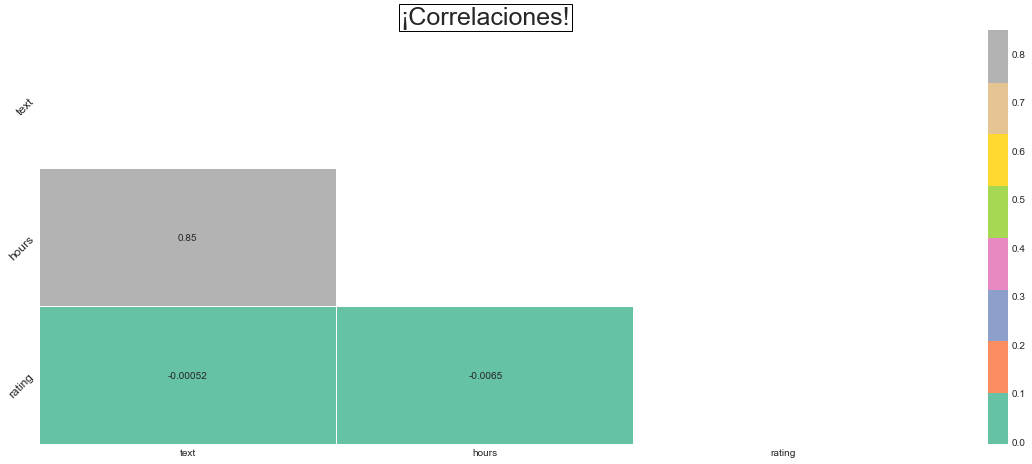

In [72]:
# Realizo un mapa de calor para observar si encontramos alguna correlación
correlacion =top_coments.corr()
matrix=np.triu(correlacion)
fig, ax = plt.subplots(figsize=[20,10])
ax = sns.heatmap(correlacion,cmap='Set2', annot = True, linewidths=.5,mask=matrix)
plt.subplots_adjust(top=0.7)
ax.set_title ('¡Correlaciones!',fontsize=25,bbox={'facecolor':'1','pad':2})
plt.tick_params(axis='y', labelrotation=45, labelsize =12)
plt.show()

* Nos encontramos con una correlación del 85% entre la cantidad de horas jugadas y las menciones, cuantas más horas juegan los usuarios más comentarios dejan. Entendemos que esta relación nos puede ayudar a mejorar nuestro modelo. Consideremos la relevancia que tienen las horas de juego al momento de comentar. Recordemos también que nuestro rating está construido con los comentarios. Por tanto, podemos concluir que las horas tienen una relación muy fuerte con el rating.
* Por otro lado, como vimos anteriormente la calificación del Rating se ve afectada por la cantidad de horas. A mayor cantidad de horas disminuye la calificación del Rating.
* Para evitar "castigar" a los juegos más populares (esto iría en contra de nuestro modelo) vamos a crear un nuevo Rating por relevancia considerando las horas. Pero no es la única mejora que podemos realizar a nuestros datos.
* Si partimos del supuesto que los juegos calificados como "malos" realmente lo son. Puede ser una buena idea filtrarlos y que no estén en nuestro modelo. 
* Si además consideramos que los usuarios con pocos comentarios son relativamente menos activos, entonces tampoco vamos a querer estos datos en nuestro sistema de recomendación.
* Podemos utilizar estos dos enfoques para mejorar la calidad de nuestro input.
* **Primer hipótesis: “Garbage in, garbage out”. Reducir el volumen de datos en la búsqueda de mejorar la calidad de entrada hará mejor a nuestro modelo.**
* **Segunda hipótesis: Enriquecer nuestro Rating ponderando la cantidad de horas de juego ajustara la calificación de forma eficiente mejorando nuestro modelo.**

In [73]:
# Primero vamos a eliminar los juegos "impopulares" (de acuerdo a su rating).
f = ['count','mean']

df_games_summary = df.groupby('product_id')['rating'].agg(f)
df_games_summary.index = df_games_summary.index.map(int)
games_benchmark = round(df_games_summary['count'].quantile(0.7),0)
drop_games_list = df_games_summary[df_games_summary['count'] < games_benchmark].index

print('Games minimum times of review: {}'.format(games_benchmark))

# Además vamos a eliminar los usuarios menos activos.
df_user_summary = df.groupby('user_id')['rating'].agg(f)
df_user_summary.index = df_user_summary.index.map(int)
user_benchmark = round(df_user_summary['count'].quantile(0.7),0)
drop_user_list = df_user_summary[df_user_summary['count'] < user_benchmark].index

# Imprimo el Shape original vs el nuevo Shape luego que removemos los datos que no nos interesan.
print('Original Shape: {}'.format(df.shape))
df = df[~df['product_id'].isin(drop_games_list)]
df = df[~df['user_id'].isin(drop_user_list)]
print('After Trim Shape: {}'.format(df.shape))

Games minimum times of review: 16.0
Original Shape: (779951, 17)
After Trim Shape: (743402, 17)


In [74]:
# Ahora eliminamos los NaNs de las horas para crear nuestro "Rating por relevancia" considerando las horas de juego. 
df = df.dropna(subset=['hours'])

In [75]:
# Vamos a agrupar las horas entre -1 y 1
scaler_min_max = preprocessing.MinMaxScaler(feature_range=(-1,1))
hours_scaled = scaler_min_max.fit_transform(df[['hours']])
df_hours_scaled = pd.DataFrame(hours_scaled)

# Agregamos la columna con las horas escaladas.
df[['hours_scaled']]=df_hours_scaled

# Eliminamos los NaNs
df = df.dropna(subset=['hours_scaled'])

# Creamos el rating por relevancia sumando la columna original del rating y las horas escaladas.
df['relevance_rating']= df['rating']+ df['hours_scaled']

# Normalizamos nuestro nuevo rating con la ponderación de "5 estrellas"
df['relevance_rating']= min_max_scaler.fit_transform(df[['relevance_rating']])
df.head()

,username,hours,product_id,text,user_id,publisher,genres,app_name,tags,specs,price,early_access,id,developer,sentiment,lemma_comments,rating,hours_scaled,relevance_rating
12,the_maker988,8.2,35140,"this game was way to linear for me, and compar...",503851,"warner bros. interactive entertainment, feral ...",action adventure,batman: arkham asylum game of the year edition,action batman stealth adventure ...,single player steam achievements steam...,19.99,False,35140,rocksteady studios feral interactive mac,9.0,0.5859,4.1718,-0.963071,3.139200
13,mlgarbage,9.5,35140,fun game. i played shadow of mordor before pla...,207702,"warner bros. interactive entertainment, feral ...",action adventure,batman: arkham asylum game of the year edition,action batman stealth adventure ...,single player steam achievements steam...,19.99,False,35140,rocksteady studios feral interactive mac,9.0,0.8225,4.6450,-0.940037,3.470110
14,brookie,16.1,35140,absolutely dark as a bag. love this game.,51838,"warner bros. interactive entertainment, feral ...",action adventure,batman: arkham asylum game of the year edition,action batman stealth adventure ...,single player steam achievements steam...,19.99,False,35140,rocksteady studios feral interactive mac,9.0,0.6682,4.3364,-0.967459,3.246036
15,anotherphysicsgradstudent,56.9,35140,"it may be close to a decade old, but don't let...",403603,"warner bros. interactive entertainment, feral ...",action adventure,batman: arkham asylum game of the year edition,action batman stealth adventure ...,single player steam achievements steam...,19.99,False,35140,rocksteady studios feral interactive mac,9.0,0.9825,4.9650,-0.952468,3.675209
16,bouncedbadger123,54.2,35140,"good story and graphics for 2009, only downsid...",49634,"warner bros. interactive entertainment, feral ...",action adventure,batman: arkham asylum game of the year edition,action batman stealth adventure ...,single player steam achievements steam...,19.99,False,35140,rocksteady studios feral interactive mac,9.0,0.5859,4.1718,-0.959415,3.141638


In [76]:
# Creamos una copia de nuestros datos para diferenciarlos de nuestra primer versión.
df_2=df.copy()

# Guardamos una copia del dataset preprocesado versión 2.
df_2.to_csv('clean_data_v2.csv')

In [77]:
# Levantamos los datos del dataset dataset preprocesado versión 2.
clean_data_v2= pd.read_csv ('clean_data_v2.csv')# De esta manera optimizamos el tiempo.
clean_data_v2.head()

,Unnamed: 0,username,hours,product_id,text,user_id,publisher,genres,app_name,tags,specs,price,early_access,id,developer,sentiment,lemma_comments,rating,hours_scaled,relevance_rating
0,12,the_maker988,8.2,35140,"this game was way to linear for me, and compar...",503851,"warner bros. interactive entertainment, feral ...",action adventure,batman: arkham asylum game of the year edition,action batman stealth adventure ...,single player steam achievements steam...,19.99,False,35140,rocksteady studios feral interactive mac,9.0,0.5859,4.1718,-0.963071,3.139200
1,13,mlgarbage,9.5,35140,fun game. i played shadow of mordor before pla...,207702,"warner bros. interactive entertainment, feral ...",action adventure,batman: arkham asylum game of the year edition,action batman stealth adventure ...,single player steam achievements steam...,19.99,False,35140,rocksteady studios feral interactive mac,9.0,0.8225,4.6450,-0.940037,3.470110
2,14,brookie,16.1,35140,absolutely dark as a bag. love this game.,51838,"warner bros. interactive entertainment, feral ...",action adventure,batman: arkham asylum game of the year edition,action batman stealth adventure ...,single player steam achievements steam...,19.99,False,35140,rocksteady studios feral interactive mac,9.0,0.6682,4.3364,-0.967459,3.246036
3,15,anotherphysicsgradstudent,56.9,35140,"it may be close to a decade old, but don't let...",403603,"warner bros. interactive entertainment, feral ...",action adventure,batman: arkham asylum game of the year edition,action batman stealth adventure ...,single player steam achievements steam...,19.99,False,35140,rocksteady studios feral interactive mac,9.0,0.9825,4.9650,-0.952468,3.675209
4,16,bouncedbadger123,54.2,35140,"good story and graphics for 2009, only downsid...",49634,"warner bros. interactive entertainment, feral ...",action adventure,batman: arkham asylum game of the year edition,action batman stealth adventure ...,single player steam achievements steam...,19.99,False,35140,rocksteady studios feral interactive mac,9.0,0.5859,4.1718,-0.959415,3.141638


In [78]:
# Creamos el dataset con la versión 2 de nuestros datos en el formato que requiere la biblioteca.
data_2 = Dataset.load_from_df(clean_data_v2[['user_id', 'product_id', 'relevance_rating']], reader=reader)

In [79]:
# Dividimos nuestros datos en entrenamiento y testeo.
trainset, testset = train_test_split(data_2, test_size=.30,random_state=42)

### Modelo 2: “Garbage in, garbage out”.

In [80]:
# Creamos la versión 2 de nuestro sistema de recomendación 
recommender_2 = SVD()

In [81]:
# Lo entrenamos con nuestros datos de train versión 2.
recommender_2.fit(trainset)

In [82]:
# Realizamos predicciones con nuestros datos de test versión 2.
predictions = recommender_2.test(testset)

In [83]:
# Evaluamos su RMSE versión 2
accuracy.mae(predictions)
accuracy.rmse(predictions)

MAE:  0.5732
RMSE: 0.7139


0.7139162858858958

* ¡Acertamos con nuestras hipótesis! Simplemente mejorando la calidad de los datos (para eso antes tuvimos que reducirlos) logramos una mejora en nuestro RMSE de un 27%. 
* El nuevo Rating considerando la relevancia de las horas de juego definitivamente logro a ayudar a mejorar nuestro sistema de recomendación. 
* Veamos qué resultados obtenemos si lo optimizamos.

### Optimización Modelo 2: **Randomized Search “Garbage in, garbage out”**


In [84]:
# Volvemos a utilizar Randomized en búsqueda de los mejores hiperparámetros y mejorar nuestro modelo versión 2.
random_grid = {'n_factors': [5,50,100],'n_epochs': [5, 10,20], 'lr_all': [0.001, 0.002, 0.005],
              'reg_all': [0.002, 0.02, 0.2]}
rs_2 = RandomizedSearchCV(SVD, random_grid, measures=['rmse'], cv=3, n_jobs = -1)
# Lo entreno
rs_2.fit(data_2)

In [85]:
# Imprimo el mejor score obtenido y con que hiperparámetros lo conseguimos.

print(rs_2.best_score['rmse'])
print(rs_2.best_params['rmse'])

0.7131611423251846
{'n_factors': 5, 'n_epochs': 5, 'lr_all': 0.005, 'reg_all': 0.02}


* ¡Atención! No mejoran los resultados con la optimización (hay mejora pero es muy marginal). Esto reafirma aún más nuestras hipótesis, es más relevante mejorar la calidad de los datos de entrada para conseguir mejores resultados. Incluso más que optimizar.

---

### Modelo 3: “Relevance Rating games”.

* Vamos a aplicar el mismo criterio que utilizamos con las horas pero ahora con la relevancia de la calificación del juego.
* Como vimos en nuestro EDA, contamos con una columna ('sentiment') que nos trae la calificación que tiene trae el juego (de acuerdo a lo calificado por STEAM).
* Resulta relevante e importante que nuestro sistema de recomendación considere dentro de su Rating la calificación que STEAM le otorga a sus juegos.
* Veamos que resultados obtenemos:

In [86]:
# Primero vamos a escalar la columna de la calificación del juego por parte de STEAM entre -1 y 1

sentiment_scaled = scaler_min_max.fit_transform(df[['sentiment']])
df_sentiment_scaled = pd.DataFrame(sentiment_scaled)

# Agregamos la columna con la calificación del juego escalada.
df[['sentiment_scaled']]=df_sentiment_scaled

# Eliminamos los NaNs
df = df.dropna(subset=['sentiment_scaled'])

# Creamos un nuevo rating por relevancia sumando la columna original del rating y lla calificación del juego escalada.
df['relevance_rating_2']= df['rating']+ df['sentiment_scaled']

# Normalizamos nuestro nuevo rating con la ponderación de "5 estrellas"
df['relevance_rating_2']= min_max_scaler.fit_transform(df[['relevance_rating_2']])
df.head()

,username,hours,product_id,text,user_id,publisher,genres,app_name,tags,specs,...,early_access,id,developer,sentiment,lemma_comments,rating,hours_scaled,relevance_rating,sentiment_scaled,relevance_rating_2
12,the_maker988,8.2,35140,"this game was way to linear for me, and compar...",503851,"warner bros. interactive entertainment, feral ...",action adventure,batman: arkham asylum game of the year edition,action batman stealth adventure ...,single player steam achievements steam...,...,False,35140,rocksteady studios feral interactive mac,9.0,0.5859,4.1718,-0.963071,3.139200,1.0,4.444329
13,mlgarbage,9.5,35140,fun game. i played shadow of mordor before pla...,207702,"warner bros. interactive entertainment, feral ...",action adventure,batman: arkham asylum game of the year edition,action batman stealth adventure ...,single player steam achievements steam...,...,False,35140,rocksteady studios feral interactive mac,9.0,0.8225,4.6450,-0.940037,3.470110,1.0,4.761817
14,brookie,16.1,35140,absolutely dark as a bag. love this game.,51838,"warner bros. interactive entertainment, feral ...",action adventure,batman: arkham asylum game of the year edition,action batman stealth adventure ...,single player steam achievements steam...,...,False,35140,rocksteady studios feral interactive mac,9.0,0.6682,4.3364,-0.967459,3.246036,1.0,4.554765
15,anotherphysicsgradstudent,56.9,35140,"it may be close to a decade old, but don't let...",403603,"warner bros. interactive entertainment, feral ...",action adventure,batman: arkham asylum game of the year edition,action batman stealth adventure ...,single player steam achievements steam...,...,False,35140,rocksteady studios feral interactive mac,9.0,0.9825,4.9650,-0.952468,3.675209,1.0,4.976517
16,bouncedbadger123,54.2,35140,"good story and graphics for 2009, only downsid...",49634,"warner bros. interactive entertainment, feral ...",action adventure,batman: arkham asylum game of the year edition,action batman stealth adventure ...,single player steam achievements steam...,...,False,35140,rocksteady studios feral interactive mac,9.0,0.5859,4.1718,-0.959415,3.141638,1.0,4.444329


In [87]:
# Creamos una nueva copia de nuestros datos.
df_3=df.copy()

# Guardamos una copia del dataset preprocesado versión 3.
df_3.to_csv('clean_data_v3.csv')

In [88]:
# Levantamos los datos del dataset dataset preprocesado versión 3.
clean_data_v3= pd.read_csv ('clean_data_v3.csv')# De esta manera optimizamos el tiempo.
clean_data_v3.head()

,Unnamed: 0,username,hours,product_id,text,user_id,publisher,genres,app_name,tags,...,early_access,id,developer,sentiment,lemma_comments,rating,hours_scaled,relevance_rating,sentiment_scaled,relevance_rating_2
0,12,the_maker988,8.2,35140,"this game was way to linear for me, and compar...",503851,"warner bros. interactive entertainment, feral ...",action adventure,batman: arkham asylum game of the year edition,action batman stealth adventure ...,...,False,35140,rocksteady studios feral interactive mac,9.0,0.5859,4.1718,-0.963071,3.139200,1.0,4.444329
1,13,mlgarbage,9.5,35140,fun game. i played shadow of mordor before pla...,207702,"warner bros. interactive entertainment, feral ...",action adventure,batman: arkham asylum game of the year edition,action batman stealth adventure ...,...,False,35140,rocksteady studios feral interactive mac,9.0,0.8225,4.6450,-0.940037,3.470110,1.0,4.761817
2,14,brookie,16.1,35140,absolutely dark as a bag. love this game.,51838,"warner bros. interactive entertainment, feral ...",action adventure,batman: arkham asylum game of the year edition,action batman stealth adventure ...,...,False,35140,rocksteady studios feral interactive mac,9.0,0.6682,4.3364,-0.967459,3.246036,1.0,4.554765
3,15,anotherphysicsgradstudent,56.9,35140,"it may be close to a decade old, but don't let...",403603,"warner bros. interactive entertainment, feral ...",action adventure,batman: arkham asylum game of the year edition,action batman stealth adventure ...,...,False,35140,rocksteady studios feral interactive mac,9.0,0.9825,4.9650,-0.952468,3.675209,1.0,4.976517
4,16,bouncedbadger123,54.2,35140,"good story and graphics for 2009, only downsid...",49634,"warner bros. interactive entertainment, feral ...",action adventure,batman: arkham asylum game of the year edition,action batman stealth adventure ...,...,False,35140,rocksteady studios feral interactive mac,9.0,0.5859,4.1718,-0.959415,3.141638,1.0,4.444329


In [89]:
# Creamos el dataset con la versión 3 de nuestros datos en el formato que requiere la biblioteca.
data_3 = Dataset.load_from_df(clean_data_v3[['user_id', 'product_id', 'relevance_rating_2']], reader=reader)

In [90]:
# Dividimos nuestros datos en entrenamiento y testeo.
trainset, testset = train_test_split(data_3, test_size=.30,random_state=42)

In [91]:
# Creamos la versión 3 de nuestro sistema de recomendación 
recommender_3 = SVD()

In [92]:
# Lo entrenamos con nuestros datos de train versión 3.
recommender_3.fit(trainset)

In [93]:
# Realizamos predicciones con nuestros datos de test versión 3.
predictions = recommender_3.test(testset)

In [94]:
# Evaluamos su RMSE versión 3
accuracy.mae(predictions)
accuracy.rmse(predictions)

MAE:  0.5515
RMSE: 0.6717


0.6716654497275514

* **¡ESTUPENDO!** Logramos *una mejora del *¡31%!** vs nuestro modelo benchmark.
* Incluso mejoramos nuestro modelo 2 en un *6%.*
* Vamos a optimizar nuestro modelo ganador para alcanzar el máximo rendimiento posible.

### Optimización Modelo 3: **Randomized Search “Relevance Rating games”**

In [95]:
# Volvemos a utilizar Randomized en búsqueda de los mejores hiperparámetros y mejorar nuestro modelo versión 3.
random_grid = {'n_factors': [5,50,100],'n_epochs': [5, 10,20], 'lr_all': [0.001, 0.002, 0.005],
              'reg_all': [0.002, 0.02, 0.2]}
rs_3 = RandomizedSearchCV(SVD, random_grid, measures=['rmse'], cv=3, n_jobs = -1)
# Lo entreno
rs_3.fit(data_3)

In [96]:
# Imprimo el mejor score obtenido y con que hiperparámetros lo conseguimos.

print(rs_3.best_score['rmse'])
print(rs_3.best_params['rmse'])

0.6710918527583519
{'n_factors': 5, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.02}


* Ratificamos nuestro supuesto. Mejorar la calidad de los datos de entrada es lo más importante. Incluso más que optimizar.
* Dedicarle un tiempo considerable a la exploración de datos y apoyarse en las conclusiones que logremos obtener es clave para nuestro resultado.
---

* A nuestra última iteración vamos a sumar otros algoritmos básicos pero precisos que nos serán útiles para comparar precisiones.

### Modelo 4 "Comparación de algoritmos".

In [97]:
# Creamos el tercer modelo con la comparación de otros algoritmos simples.
recommender_4 = [SVD(), SVDpp(), BaselineOnly(), SlopeOne()]

names = [recommender_4[i].__class__.__name__ for i in range(len(recommender_4))]

result = np.zeros((len(recommender_4),4))            
for i in range(len(recommender_4)):
    print('Procesando ', names[i], '...')
    tab = cross_validate(recommender_4[i], data_3,cv=3, verbose = False)
    rmse = np.mean(tab['test_rmse']).round(3)
    mae = np.mean(tab['test_mae']).round(3)
    ft = np.mean(tab['fit_time']).round(3)
    tt = np.mean(tab['test_time']).round(3)
    result[i]=[rmse, mae, ft, tt]
    
result = result.round(3)
result = pd.DataFrame(result, index = names, columns =['RMSE','MAE','fit_time','test_time'])

Procesando  SVD ...
Procesando  SVDpp ...
Procesando  BaselineOnly ...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Procesando  SlopeOne ...


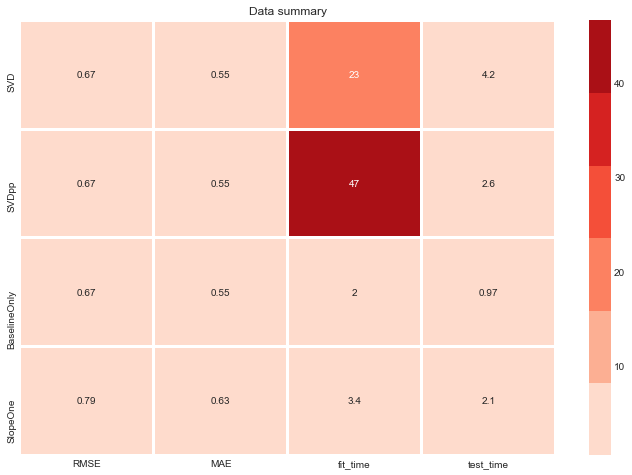

In [98]:
# Graficamos su resultado.
plt.figure(figsize=(12,8))
sns.heatmap(result,
            annot=True,linecolor="w",
            linewidth=2,cmap=sns.color_palette("Reds"))
plt.title("Data summary")
plt.show()

* Los resultados muestran que singular value decomposition tiene elmejor desempeño tanto en el Root Mean Squared Error (RMSE) como en Mean Absolute Error (MAE).
* Aunque a considerar que BaselineOnly alcanza un RMSE similar.
---

## Conclusiones finales: 

* **La calidad de los datos es determinante**, incluso por encima del proceso de optimización.
* El Rating es importante para los sistemas de recomendación, pero resulta **muy relevante** realizar un análisis exploratorio exhaustivo que nos permita **comprender de la relevancia de los atributos que impactan en ese Rating.**
* El famoso algoritmo SVD es superior en su desempeño que otros algoritmos simples, pero también precisos. Esto nos permite una comparación que enriquece el análisis de los resultados.


In [99]:
# Vemos finalmente cuanto tiempo le tomo ejecutar todo el código.
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 4:38:00.389745
